In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

In [2]:

train_dir = '/Users/chamidiperera/Downloads/Datasets/train'
validation_dir = '/Users/chamidiperera/Downloads/Datasets/valid'
test_dir = '/Users/chamidiperera/Downloads/Datasets/test'

In [3]:

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 12447 images belonging to 8 classes.


In [5]:

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 888 images belonging to 8 classes.


In [6]:

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 562 images belonging to 8 classes.


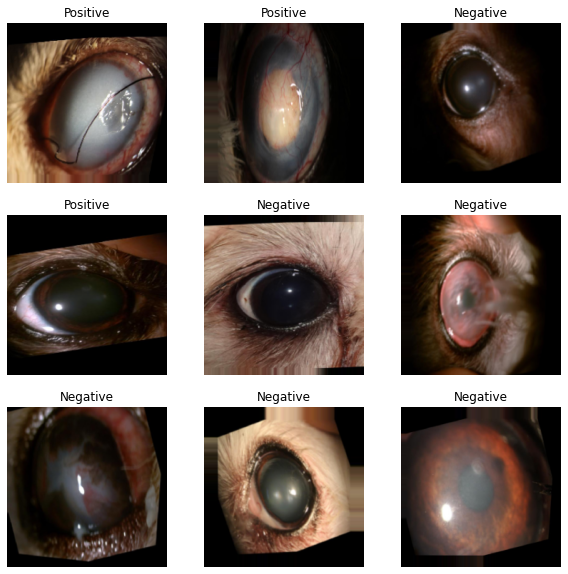

In [7]:

batch = train_generator.next()
images, labels = batch[0], batch[1]

label_names = ['Circular Alopecia', 'Flees', 'Healthy', 'RunLong', 'Skin Lesions']

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    
    label_index = np.argmax(labels[i])
    label = label_names[label_index]
    
    plt.title(label)
    plt.axis("off")
plt.show()


In [8]:

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 8s 1us/step


In [9]:

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [10]:

history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[early_stop])

Epoch 1/20
389/389 [==============================] - 128s 323ms/step - loss: 1.6864 - accuracy: 0.3365 - val_loss: 1.2692 - val_accuracy: 0.4932
Epoch 2/20
389/389 [==============================] - 115s 294ms/step - loss: 1.3668 - accuracy: 0.4493 - val_loss: 1.1744 - val_accuracy: 0.5315
Epoch 3/20
389/389 [==============================] - 117s 300ms/step - loss: 1.2751 - accuracy: 0.4743 - val_loss: 1.1550 - val_accuracy: 0.5360
Epoch 4/20
389/389 [==============================] - 113s 290ms/step - loss: 1.2254 - accuracy: 0.4917 - val_loss: 1.0984 - val_accuracy: 0.5552
Epoch 5/20
389/389 [==============================] - 113s 289ms/step - loss: 1.2019 - accuracy: 0.5088 - val_loss: 1.0894 - val_accuracy: 0.5597
Epoch 6/20
389/389 [==============================] - 112s 289ms/step - loss: 1.1681 - accuracy: 0.5241 - val_loss: 1.0700 - val_accuracy: 0.5698
Epoch 7/20
389/389 [==============================] - 116s 299ms/step - loss: 1.1676 - accuracy: 0.5145 - val_loss: 1.0766 -

In [11]:

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

18/18 [==============================] - 4s 209ms/step - loss: 1.1393 - accuracy: 0.5356
Test Accuracy: 0.5355871915817261


In [12]:

model.save('MobileNetV2_multi_detect.h5')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


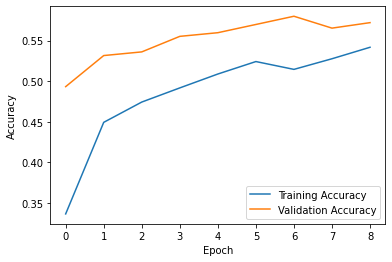

In [13]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()